**TRAFFIC SIGNS RECOGNITION FOR ADAS**

cloning data set to be used for the training of classification model


In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


importing necessary python packages


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd

In [4]:
np.random.seed(0)

unpacking downloaded data into training validation and test set

In [5]:
#unpickeling thw data files from the directory
with open('german-traffic-signs/train.p','rb') as file:
  train_data = pickle.load(file)
with open('german-traffic-signs/valid.p','rb') as file:
  val_data = pickle.load(file)
with open('german-traffic-signs/test.p','rb') as file:
  test_data = pickle.load(file)

#converting the data of key value pair into array of data
X_train,y_train = train_data['features'],train_data['labels']
X_val,y_val = val_data['features'],val_data['labels']
X_test,y_test = test_data['features'],test_data['labels']

In [6]:
assert(X_train.shape[0] == y_train.shape[0]),'number of labels and the number of features are not equal'
assert(X_val.shape[0] == y_val.shape[0]),'number of labels and the number of features are not equal'
assert(X_test.shape[0] == y_test.shape[0]),'number of labels and the number of features are not equal'

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]
 
cols = 5
num_classes = 43
 

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      
      if i == 2:
        
        num_of_samples.append(len(x_selected))

In [8]:
import cv2



defining functions for input data preprocessing

In [9]:
def grayscale(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img



In [10]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img



In [11]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img /255
  return img

**DATA PREPROCESSING**:

Preprocessing training,valiidation and test data

In [12]:
X_train = np.array(list(map(preprocessing,X_train)))
X_val = np.array(list(map(preprocessing,X_val)))
X_test = np.array(list(map(preprocessing,X_test)))

In [13]:
#adding dimensions
X_train = X_train.reshape(34799, 32, 32,1)
X_test = X_test.reshape(12630, 32, 32,1)
X_val = X_val.reshape(4410, 32, 32,1)

In [29]:
#synthetic data generation/augmented data
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range = 0.1,
                   zoom_range = 0.2,
                   shear_range = 0.1,
                   rotation_range = 10)
datagen.fit(X_train)


data red hot encoding

In [30]:
#red hot encoding of the labels
y_train = to_categorical(y_train , num_classes)
y_test = to_categorical(y_test , num_classes)
y_val = to_categorical(y_val , num_classes)

**MODEL ARCHITECTURE**

creating model architecture for classification


In [16]:
def leNet():
  model = Sequential()
  model.add(Conv2D(60,(5,5),input_shape = (32,32,1),activation = 'relu'))
  model.add(Conv2D(60,(5,5),activation = 'relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Flatten())
  model.add(Dense(500,activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation='softmax'))
  #compiling the model
  model.compile(Adam(lr = 0.001),'categorical_crossentropy',metrics = ['accuracy'])
  return model

**TRAINING MODEL**

training the model for 10 epochs

In [17]:
model = leNet()
h = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=X_train.shape[0]/50,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
695/695 [==============================] - 17s 15ms/step - loss: 2.7575 - accuracy: 0.2452 - val_loss: 0.3331 - val_accuracy: 0.8816
Epoch 2/10
695/695 [==============================] - 10s 15ms/step - loss: 0.6473 - accuracy: 0.7964 - val_loss: 0.1076 - val_accuracy: 0.9698
Epoch 3/10
695/695 [==============================] - 10s 15ms/step - loss: 0.3389 - accuracy: 0.8925 - val_loss: 0.0853 - val_accuracy: 0.9741
Epoch 4/10
695/695 [==============================] - 10s 15ms/step - loss: 0.2440 - accuracy: 0.9220 - val_loss: 0.0636 - val_accuracy: 0.9832
Epoch 5/10
695/695 [==============================] - 10s 15ms/step - loss: 0.1911 - accuracy: 0.9394 - val_loss: 0.0509 - val_accuracy: 0.9819
Epoch 6/10
695/695 [==============================] - 10s 15ms/step - loss: 0.1759 - accuracy: 0.9434 - val_loss: 0.0471 - val_accuracy: 0.9853
Epoch 7/10
695/695 [==============================] - 10s 15ms/step - loss: 0.1533 - accuracy: 0.9521 - val_loss: 0.0594 - val_accuracy:

evaluating model on test set

In [18]:
score = model.evaluate(X_test,y_test)
print('loss',score[0])
print('accuracy',score[1])

395/395 [==============================] - 1s 2ms/step - loss: 0.1487 - accuracy: 0.9626
loss 0.14868418872356415
accuracy 0.9626286625862122


visualizing training behaviour


Text(0.5, 0, 'epoch')

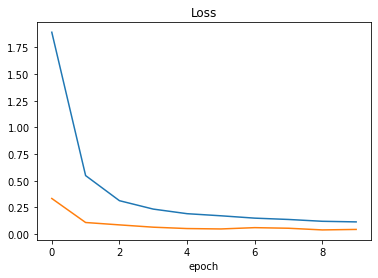

In [19]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

**MODEL VISULAIZATION**

 testing the model on a random image

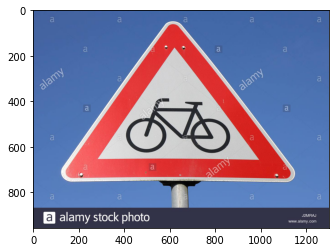

In [26]:
#predicting traffic signs
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url,stream = True)
img = Image.open(r.raw)
plt.imshow(img,cmap = plt.get_cmap('gray'))

(32, 32)


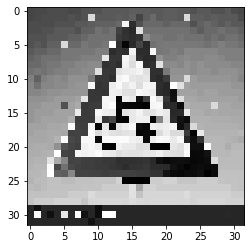

In [27]:

#preprocessing image
img = np.asarray(img)
img = cv2.resize(img,(32,32))
img = preprocessing(img)
plt.imshow(img,cmap=plt.get_cmap('gray'))
print(img.shape)

In [28]:

#adding depth
img = img.reshape(1,32,32,1)
#predicting class
data = np.asarray(data)
prediction = model.predict_classes(img)


print('prediction is:',data[prediction,1])

prediction is: ['Road narrows on the right']


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
